# Imports and Functions

In [84]:
from sunlab.globals import *
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.common.mathlib.lyapunov import *
from sunlab.sunflow import *

In [544]:
from sklearn.decomposition import PCA as lPCA
from sklearn.decomposition import KernelPCA as PCA

In [86]:
from sklearn.manifold import TSNE

In [87]:
from scipy.signal import correlate2d
from matplotlib import colors

In [88]:
def fill_between(Y, X=None, alpha=0.15, skip=2, count=4, color='green'):
    from numpy import argsort, diag, array
    if X is None:
        X = range(Y.shape[0])
    if isinstance(Y, list):
        Y = array(Y)
    assert len(Y.shape) == 2
    assert count*(1+skip) < Y.shape[1]//2
    S = argsort(Y, axis=1)
    S_min = S[:,0]
    S_max = S[:,-1]
    Y_nmin = lambda n: diag(Y[:,S[:,n]])
    Y_nmax = lambda n: diag(Y[:,S[:,S.shape[1]-n-1]])
    for i in range(count):
        index = i * (1 + skip)
        plt.gca().fill_between(X, Y_nmin(index), Y_nmax(index), alpha=alpha, color=color)

In [89]:
def find_longest_trajectory(trajectories):
    """# Find longest trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import argmin, argmax, isnan
    N = trajectories.shape[2]
    Longest = 0
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        if Longest < X.shape[0]:
            Longest = X.shape[0]
    return Longest

In [90]:
def autocorrelate_trajectory(trajectories, middle_only=True):
    """# Autocorrelate Trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import zeros, bool_, argmin, argmax, isnan
    from numpy.ma import masked_where
    N = trajectories.shape[2]
    DimensionSize = 2 * trajectories.shape[0] - 1
    if middle_only:
        DimensionSize = 1
    CorrelationSize = 2 * find_longest_trajectory(trajectories) - 1
    CorrelationMid = trajectories.shape[0] - 1
    Correlation = zeros((CorrelationSize, DimensionSize * N))
    CorrelationMask = zeros((CorrelationSize, DimensionSize * N)).astype(bool_)
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        correlation = correlate2d(X, X)
        if DimensionSize == 1:
            correlation = correlation[:,[CorrelationMid]]
        C_min = CorrelationSize // 2 - correlation.shape[0] // 2
        C_max = C_min + correlation.shape[0]
        Correlation[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = correlation
        CorrelationMask[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = True
    return Correlation, CorrelationMask, masked_where(~CorrelationMask, Correlation)

In [91]:
def plot_autocorrelation(correlation, resolution=1):
    correlation = correlation[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [92]:
def plot_trajectory_autocorrelation(trajectories, resolution=1):
    correlation = autocorrelate_trajectory(trajectories)[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [93]:
def shrink(data):
    """# Remove Nans
    data: [D,N_t,N]"""
    from numpy import argmin, argmax, isnan
    X = data[:,:,0].T # N_t x Dim
    X_max = min(data.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
    X_min = max(argmin(isnan(X), axis=0))
    X = X[X_min:X_max,:]
    return X

In [94]:
X = np.array([[0,1],[1,1],[1,0],[0,0]])
X[~np.ma.masked_where(X==0,X).mask.any(axis=-1),:]

array([[1, 1]])

In [95]:
def Persistence_t(trajectory, normalize=False):
    """# Persistence
    trajectory: [N_t, Dim]"""
    from numpy.linalg import norm
    from numpy import dot, diag, newaxis
    from numpy.ma import masked_where
    A = trajectory[0:-2,:]
    B = trajectory[1:-1,:]
    C = trajectory[2:, :]
    BA = B - A
    CB = C - B
    if normalize:
        BA_mask = ~masked_where(BA == 0, BA).mask.any(axis=-1)
        CB_mask = ~masked_where(CB == 0, CB).mask.any(axis=-1)
        _mask = BA_mask & CB_mask
        if isinstance(_mask, np.bool_):
            BA = BA
            CB = CB
        else:
            BA = BA[_mask,...]
            CB = CB[_mask,...]
        BA = (BA.T / norm(BA, axis=-1)).T
        CB = (CB.T / norm(CB, axis=-1)).T
        return diag(dot(BA, CB.T)), _mask
    return diag(dot(BA, CB.T))

In [96]:
def Motility_t(trajectory, normalize=False):
    """# Motility
    trajectory: [N_t, 2]

    Assumes the center is at the origin"""
    from numpy.linalg import norm
    from numpy import array, diag, sum
    assert len(trajectory.shape) == 2
    assert trajectory.shape[1] == 2
    A = trajectory[:-1,:]
    B = trajectory[1:,:]
    BA = B - A
    if normalize:
        BA /= norm(BA, axis=-1)
    R = A.copy() # Radial direction for the trajectory
    R = (R.T / np.linalg.norm(R, axis=-1)).T # [N_t,2]
    T = array([R[:,1],-R[:,0]]).T # Tangential direction [N_t,2]
    total_motility = BA.copy() # [N_t, 2]
    radial_motility = (diag(total_motility @ R.T) * R.T).T  # [N_t,2]
    tangential_motility = (diag(total_motility @ T.T) * T.T).T  # [N_t,2]
    return total_motility,radial_motility,tangential_motility

# Runtime Parameters

In [97]:
SAVE_EXTRAS = False

In [98]:
g_Base = lambda *args: f"{DIR_ROOT}/Figures/PCA/Invasion/ManuallyTracked/"
g_MAX_LAG = 16
g_N_GaussSmooth = 500#250
g_BoxExtra = 2e-2

# Setup

In [ ]:
model, dataset = load_aae_and_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

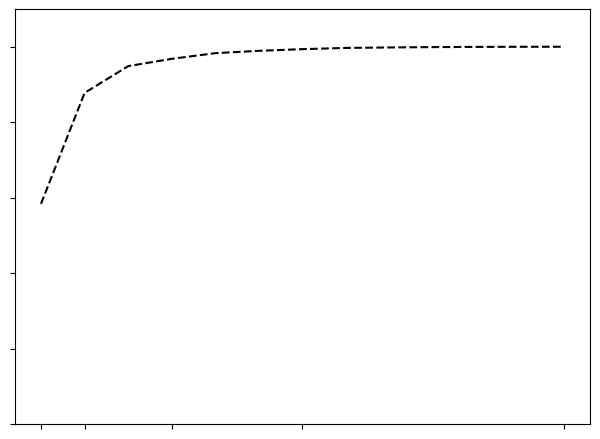

In [562]:
evr = []
for __D in range(1,13+1):
    model = lPCA(__D)
    model.fit(dataset.dataset)
    evr.append(model.explained_variance_ratio_)
plt.plot(range(1,13+1),[sum(evr_) for evr_ in evr],'k--')
plt.ylim([0,1.1])
plt.xticks([1,2,4,7,13],[1,2,4,7,13])
[sum(evr_) for evr_ in evr]
plt.save(g_Base() + "PCA-ExplainedVariance", _xticks=True, _yticks=True)

In [596]:
model, dataset = load_aae_and_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)
_scaler = model.scaler

__D = 2
model = PCA(__D)
model = PCA(__D, kernel='cosine', fit_inverse_transform=True)

#training_dataset = import_10x(FILES['TRAINING_DATASET'], scaler=_scaler)
reduced_dataset = import_10x(FILES['TRAINING_DATASET_WIDE_BERTH'], scaler=_scaler)

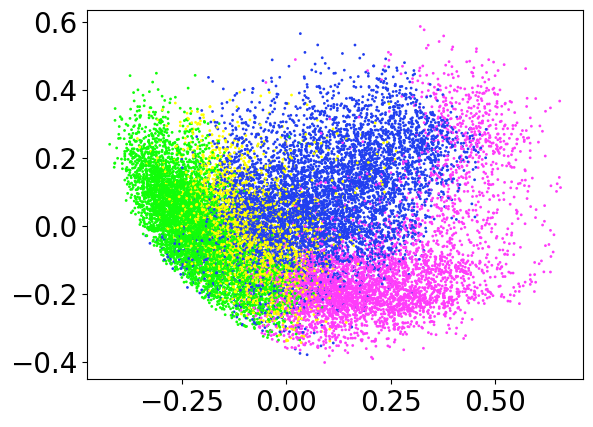

In [597]:
Y = model.fit_transform(dataset.dataset)
C = dataset.labels
plt.scatter(Y[:,0], Y[:,1], c=C, cmap=Pmap, s=1)
# plt.save(g_Base() + "CosinePCA")

In [598]:
np.mean(np.abs(dataset.dataset - model.inverse_transform(Y)))

0.3029589028211893

In [489]:
sampled_manually_tracked_trajectories = np.load_dat(FILES['FIGURES']['3']['TRAJECTORIES'])['trajectories']

In [490]:
stacked_sampled_manually_tracked_trajectories = []
max_size = np.inf
for row in sampled_manually_tracked_trajectories:
    if row.shape[0] < max_size:
        max_size = row.shape[0]
for row in sampled_manually_tracked_trajectories:
    stacked_sampled_manually_tracked_trajectories.append(row[::-1,:][:max_size,:])
stacked_sampled_manually_tracked_trajectories = np.array(stacked_sampled_manually_tracked_trajectories)
_temp = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,:13]
stacked_sampled_manually_tracked_trajectories_MFV = _scaler(_temp.reshape((-1,13))).reshape(_temp.shape)
stacked_sampled_manually_tracked_trajectories_MLV = model.transform(stacked_sampled_manually_tracked_trajectories_MFV.reshape((-1,13))).reshape((_temp.shape[0],_temp.shape[1],__D))
stacked_sampled_manually_tracked_trajectories_TISSUE = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,13:13+2]
stacked_sampled_manually_tracked_trajectories_OTHER = np.array(stacked_sampled_manually_tracked_trajectories)[:,:,13+2:]
stacked_sampled_manually_tracked_trajectories_MFV.shape,stacked_sampled_manually_tracked_trajectories_MLV.shape

((16, 20, 13), (16, 20, 2))

In [491]:
MFV_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_MFV.transpose(2,1,0))
MLV_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_MLV.transpose(2,1,0))
TISSUE_correlation = autocorrelate_trajectory(stacked_sampled_manually_tracked_trajectories_OTHER.transpose(2,1,0))

In [492]:
MAX_LAG = g_MAX_LAG

In [493]:
MFV_msds = []
for row in sampled_manually_tracked_trajectories:
    row = _scaler(row[::-1,:13])
    MFV_msds.append(mmsds(row, MAX_LAG-1))
MFV_msds = np.array(MFV_msds)
MFV_msds.shape

(16, 16)

In [494]:
MLV_msds = []
for row in sampled_manually_tracked_trajectories:
    row = model.transform(_scaler(row[::-1,:13]))
    MLV_msds.append(mmsds(row, MAX_LAG-1))
MLV_msds = np.array(MLV_msds)
MLV_msds.shape

(16, 16)

In [495]:
f_MSD = lambda x, a, b: a * x ** b

In [496]:
MFV_parameters = []
for idx in range(MFV_msds.shape[0]):
    X = range(MFV_msds.shape[1])
    Y = MFV_msds[idx,:]
    parameter = curve_fit(f_MSD, X, Y)[0]
    MFV_parameters.append(parameter)

MFV_parameters_msd = np.array(MFV_parameters)

/tmp/4113240.1.sun-gpu.q/ipykernel_29609/2571274007.py:1: RuntimeWarning: divide by zero encountered in power
  f_MSD = lambda x, a, b: a * x ** b


In [497]:
MFV_parameters_msd[:,1].mean(),MFV_parameters_msd[:,1].std()

(0.2011281022931541, 0.14606623463379698)

In [498]:
MLV_parameters = []
for idx in range(MLV_msds.shape[0]):
    X = range(MLV_msds.shape[1])
    Y = MLV_msds[idx,:]
    parameter = curve_fit(f_MSD, X, Y)[0]
    MLV_parameters.append(parameter)

MLV_parameters_msd = np.array(MLV_parameters)

/tmp/4113240.1.sun-gpu.q/ipykernel_29609/2571274007.py:1: RuntimeWarning: divide by zero encountered in power
  f_MSD = lambda x, a, b: a * x ** b


In [499]:
MLV_parameters_msd[:,1].mean(),MLV_parameters_msd[:,1].std()

(0.22773427515809946, 0.19329232237058605)

In [500]:
MFV_lyps = Lyapunov_t(stacked_sampled_manually_tracked_trajectories_MFV)
MLV_lyps = Lyapunov_t(stacked_sampled_manually_tracked_trajectories_MLV)
MFV_lyps.shape, MLV_lyps.shape

((120, 19), (120, 19))

In [501]:
MFV_lrss = RelativeDistance_t(stacked_sampled_manually_tracked_trajectories_MFV)
MLV_lrss = RelativeDistance_t(stacked_sampled_manually_tracked_trajectories_MLV)
MFV_lrss.shape, MLV_lrss.shape

((120, 19), (120, 19))

In [502]:
f_RS = lambda x, a, b: b * x + a

In [503]:
MFV_parameters = []
for idx in range(MFV_lrss.shape[0]):
    X = range(MFV_lrss.shape[1])
    Y = MFV_lrss[idx,:]
    parameter = curve_fit(f_RS, X, Y)[0]
    MFV_parameters.append(parameter)

MFV_parameters_rd = np.array(MFV_parameters)

In [504]:
MFV_parameters_rd[:,1].mean(),MFV_parameters_rd[:,1].std()

(-0.002202363228244758, 0.035655529651686786)

In [505]:
MLV_parameters = []
for idx in range(MLV_lrss.shape[0]):
    f = lambda x, a, b: b * x + a
    X = range(MLV_lrss.shape[1])
    Y = MLV_lrss[idx,:]
    parameter = curve_fit(f_RS, X, Y)[0]
    MLV_parameters.append(parameter)

MLV_parameters_rd = np.array(MLV_parameters)

In [506]:
MLV_parameters_rd[:,1].mean(),MLV_parameters_rd[:,1].std()

(-0.0058660044602325545, 0.047890595013316904)

In [507]:
_divnorm = lambda l,h,m=0: colors.TwoSlopeNorm(vmin=l, vcenter=m, vmax=h)
_divnorm_x = lambda x,im=-1e-1,iM=1e-1: _divnorm(min([im,np.min(x)]),max([iM,np.max(x)]))

# Plots

### Lyapunov

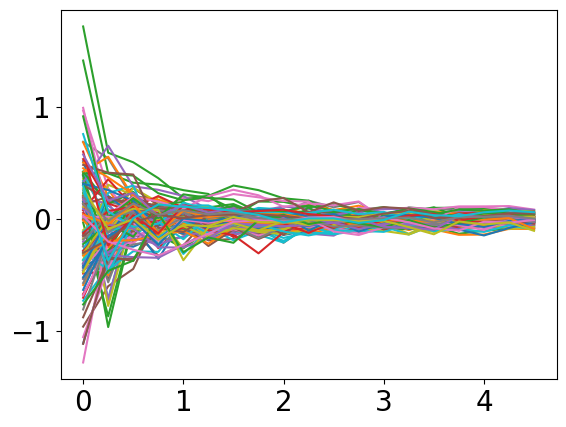

In [508]:
plt.plot(np.array(range(MFV_lyps.T.shape[0]))*0.25, MFV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MFV_time")

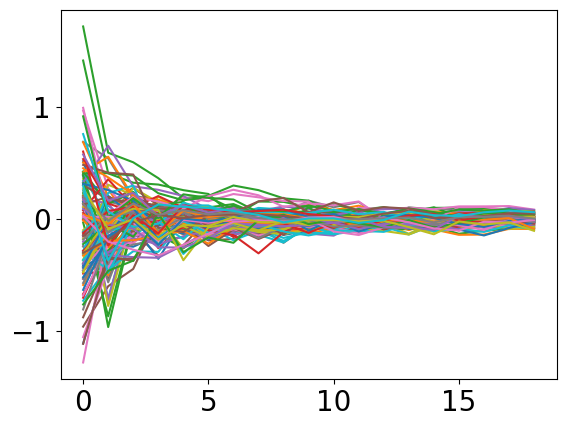

In [509]:
plt.plot(MFV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MFV")

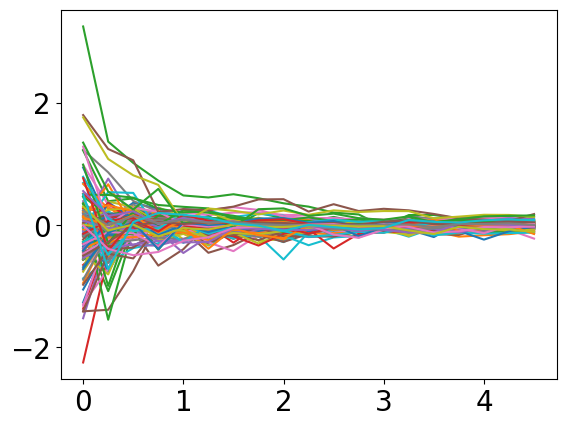

In [510]:
plt.plot(np.array(range(MLV_lyps.T.shape[0]))*0.25, MLV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MLV_time")

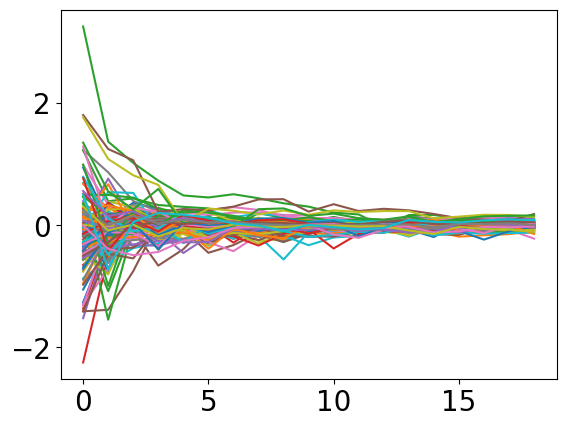

In [511]:
plt.plot(MLV_lyps.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Lyapunov/MLV")

### Log Relative Separation

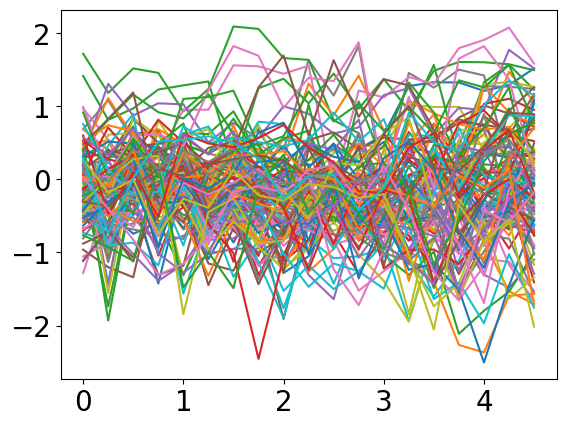

In [512]:
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_time", _xticks=True, _yticks=True, tighten=False)

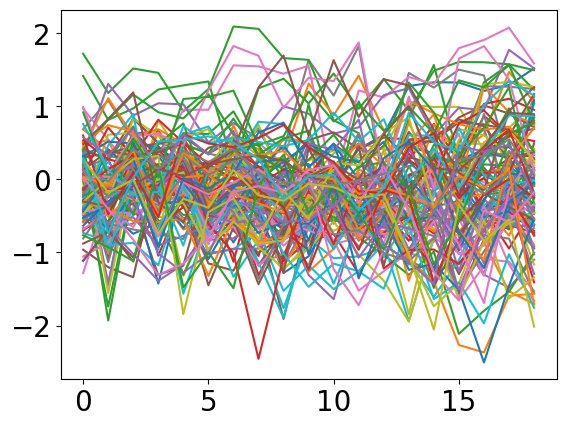

In [513]:
plt.plot(MFV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV", _xticks=True, _yticks=True, tighten=False)

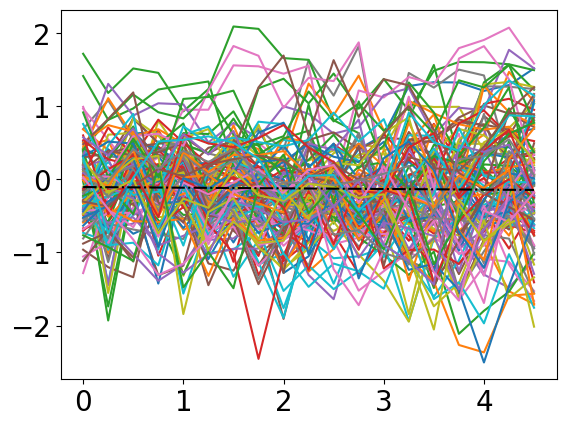

In [514]:
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T)
_T = np.mgrid[0:MFV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_dashed_time", _xticks=True, _yticks=True, tighten=False)

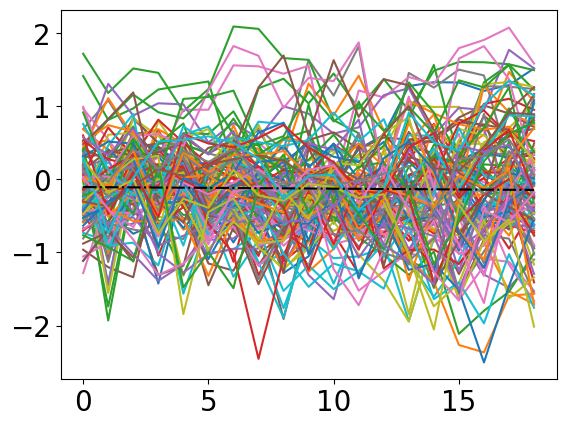

In [515]:
plt.plot(MFV_lrss.T)
_T = np.mgrid[0:MFV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MFV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_dashed", _xticks=True, _yticks=True, tighten=False)

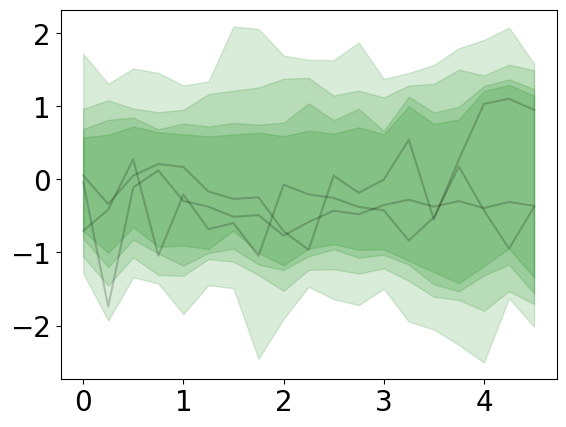

In [516]:
fill_between(MFV_lrss.T, X=np.array(range(MFV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_time", _xticks=True, _yticks=True, tighten=False)

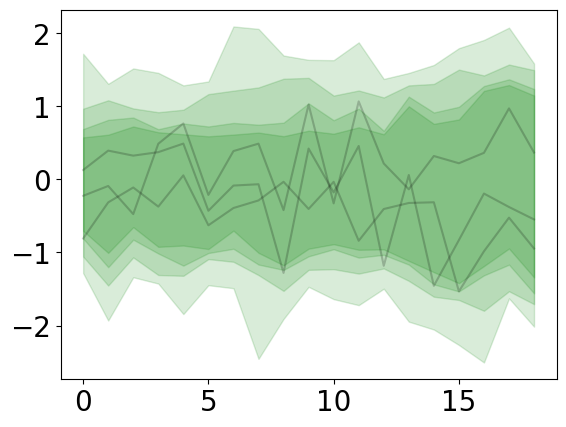

In [517]:
fill_between(MFV_lrss.T)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(MFV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density", _xticks=True, _yticks=True, tighten=False)

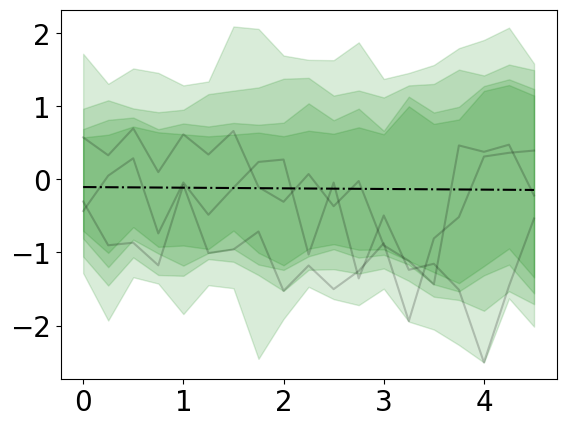

In [518]:
fill_between(MFV_lrss.T, X=np.array(range(MFV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MFV_lrss.T.shape[0]))*0.25, MFV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MFV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_dashed_time", _xticks=True, _yticks=True, tighten=False)

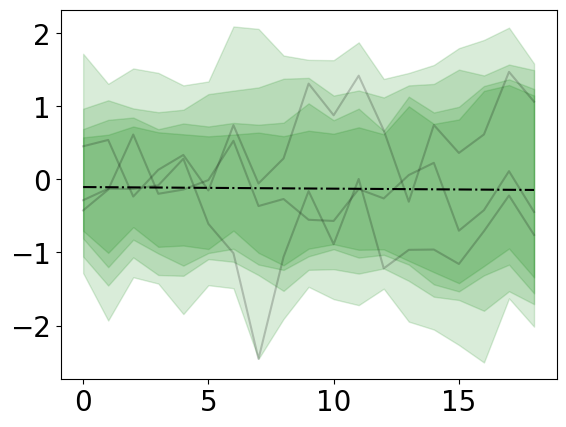

In [519]:
fill_between(MFV_lrss.T)
perm = np.random.permutation(MFV_lrss.T.shape[1])[:3]
plt.plot(MFV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MFV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MFV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_density_dashed", _xticks=True, _yticks=True, tighten=False)

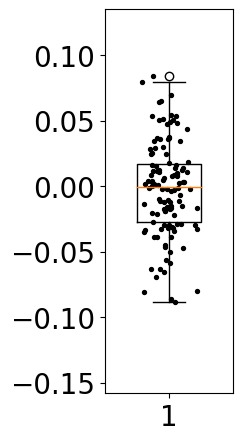

In [520]:
plt.boxplot(MFV_parameters_rd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MFV_parameters_rd.shape[0]))
plt.scatter(x,MFV_parameters_rd[:,1], s=8, color='black')
plt.ylim([min([MFV_parameters_rd[:,1].min(),MLV_parameters_rd[:,1].min()])-g_BoxExtra, max([MFV_parameters_rd[:,1].max(),MLV_parameters_rd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MFV_powers", _xticks=False, _yticks=True, tighten=False)

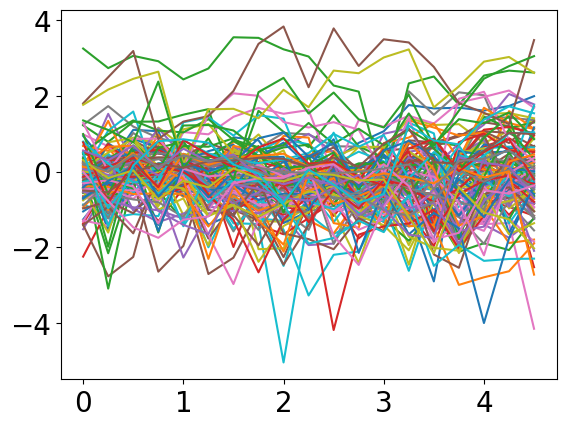

In [521]:
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_time", _xticks=True, _yticks=True, tighten=False)

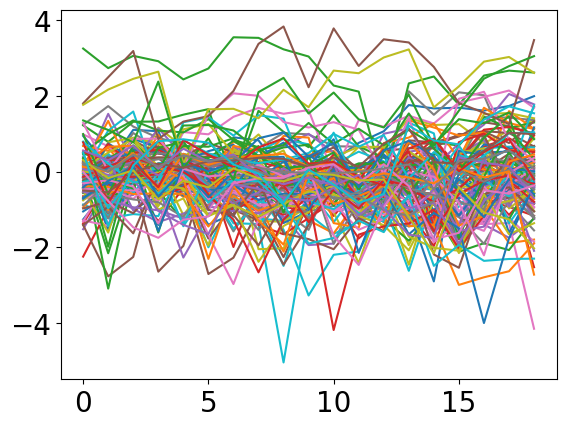

In [522]:
plt.plot(MLV_lrss.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV", _xticks=True, _yticks=True, tighten=False)

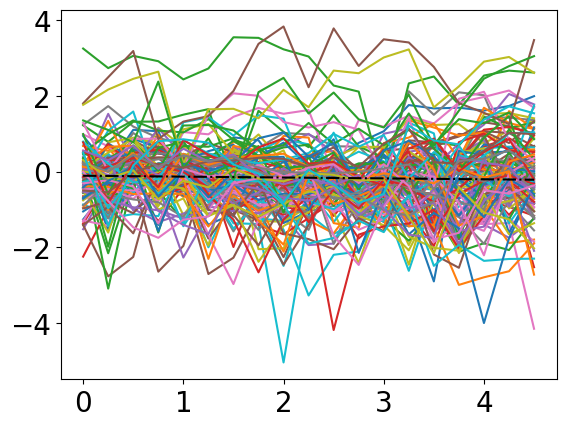

In [523]:
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T)
_T = np.mgrid[0:MLV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_dashed_time", _xticks=True, _yticks=True, tighten=False)

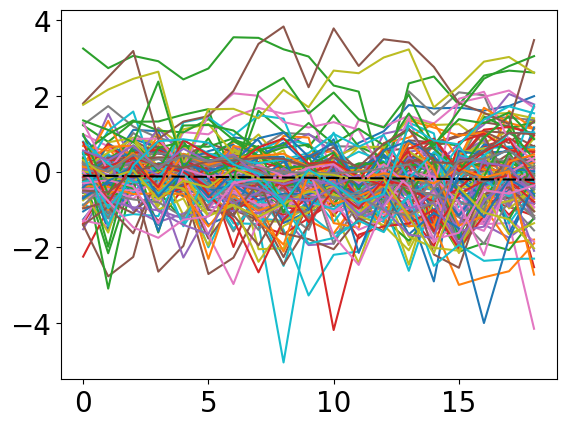

In [524]:
plt.plot(MLV_lrss.T)
_T = np.mgrid[0:MLV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MLV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_dashed", _xticks=True, _yticks=True, tighten=False)

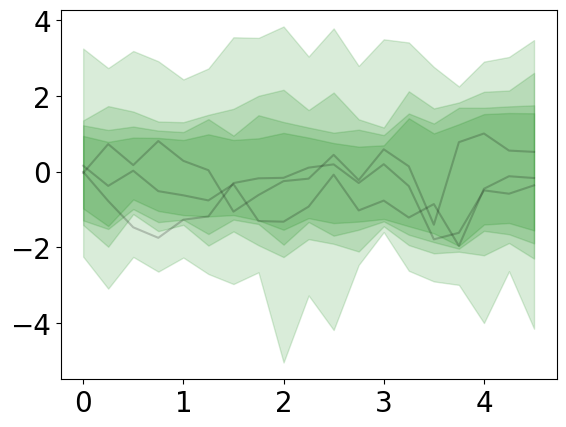

In [525]:
fill_between(MLV_lrss.T, X=np.array(range(MLV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_time", _xticks=True, _yticks=True, tighten=False)

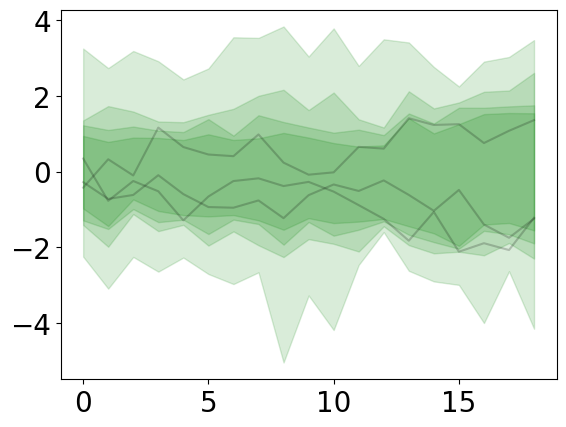

In [526]:
fill_between(MLV_lrss.T)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(MLV_lrss.T[...,perm], color='black', alpha=0.2)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density", _xticks=True, _yticks=True, tighten=False)

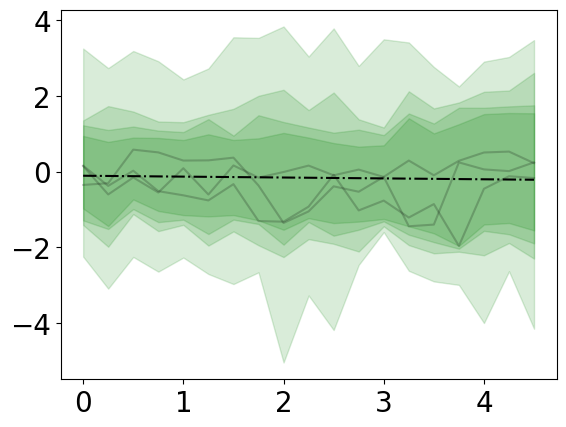

In [527]:
fill_between(MLV_lrss.T, X=np.array(range(MLV_lrss.T.shape[0]))*0.25)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(np.array(range(MLV_lrss.T.shape[0]))*0.25, MLV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MLV_lrss.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_rd,axis=0),)
plt.plot(_T, f_RS(_T, a, b*4), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_dashed_time", _xticks=True, _yticks=True, tighten=False)

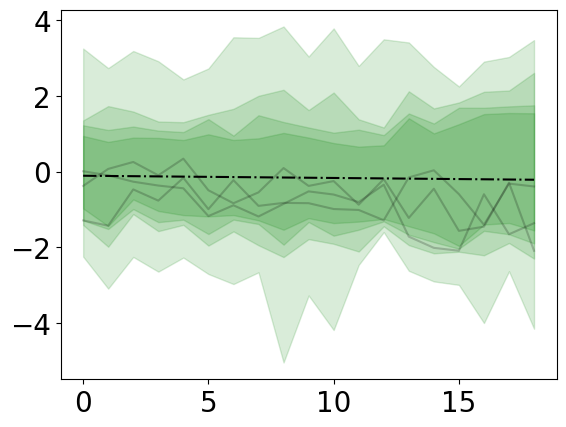

In [528]:
fill_between(MLV_lrss.T)
perm = np.random.permutation(MLV_lrss.T.shape[1])[:3]
plt.plot(MLV_lrss.T[...,perm], color='black', alpha=0.2)
_T = np.mgrid[0:MLV_lrss.T.shape[0]]
plt.plot(_T, f_RS(_T, *np.mean(MLV_parameters_rd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_density_dashed", _xticks=True, _yticks=True, tighten=False)

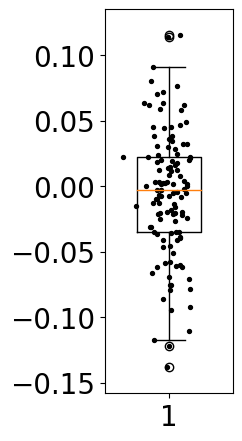

In [529]:
plt.boxplot(MLV_parameters_rd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MLV_parameters_rd.shape[0]))
plt.scatter(x,MLV_parameters_rd[:,1], s=8, color='black')
plt.ylim([min([MFV_parameters_rd[:,1].min(),MLV_parameters_rd[:,1].min()])-g_BoxExtra, max([MFV_parameters_rd[:,1].max(),MLV_parameters_rd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "LogRelativeSeparation/MLV_powers", _xticks=False, _yticks=True, tighten=False)

### MSDs

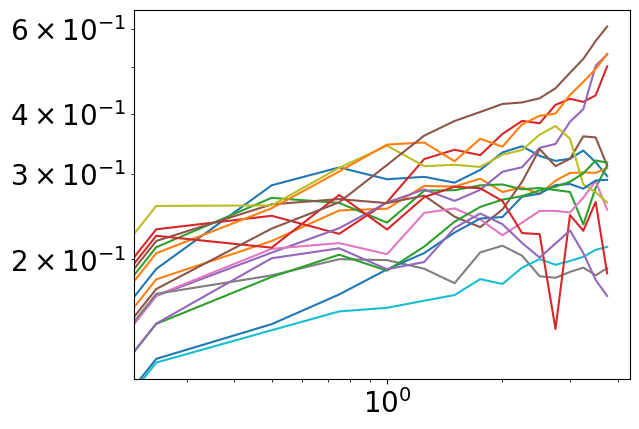

In [530]:
plt.loglog(np.array(range(MFV_msds.T.shape[0]))*0.25, MFV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_time", _xticks=True, _yticks=True, tighten=False)

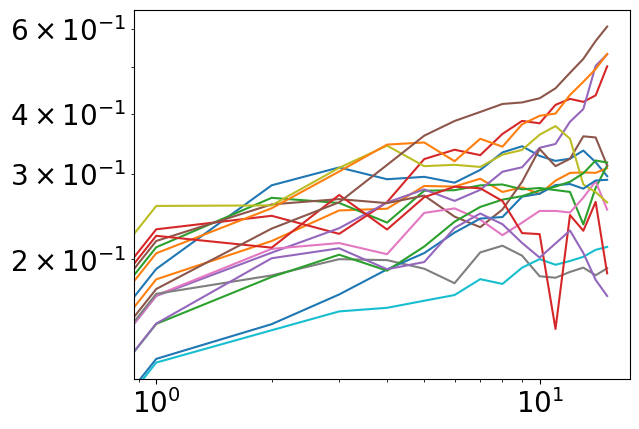

In [531]:
plt.loglog(MFV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV", _xticks=True, _yticks=True, tighten=False)

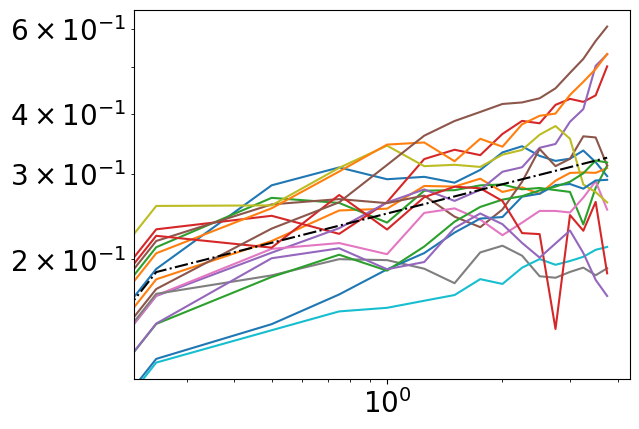

In [532]:
plt.loglog(np.array(range(MFV_msds.T.shape[0]))*0.25, MFV_msds.T)
_T = np.mgrid[0:MFV_msds.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MFV_parameters_msd,axis=0),)
plt.plot(_T, f_MSD(_T, a*(4 ** b), b), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_dashed_time", _xticks=True, _yticks=True, tighten=False)

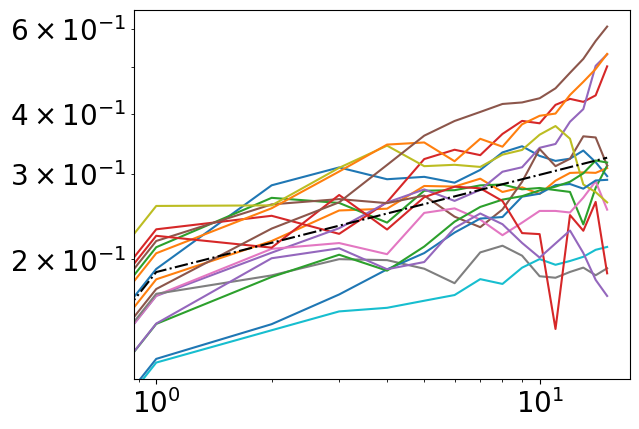

In [533]:
plt.loglog(MFV_msds.T)
_T = np.mgrid[0:MFV_msds.T.shape[0]]
plt.plot(_T, f_MSD(_T, *np.mean(MFV_parameters_msd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_dashed", _xticks=True, _yticks=True, tighten=False)

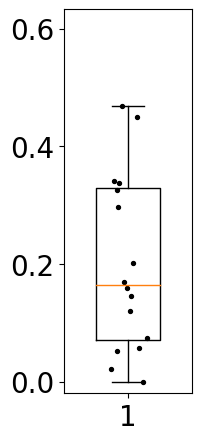

In [534]:
plt.boxplot(MFV_parameters_msd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MFV_parameters_msd.shape[0]))
plt.scatter(x,MFV_parameters_msd[:,1], s=8, color='black')
plt.ylim([0-g_BoxExtra,max([MFV_parameters_msd[:,1].max(),MLV_parameters_msd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MFV_powers", _xticks=False, _yticks=True, tighten=False)

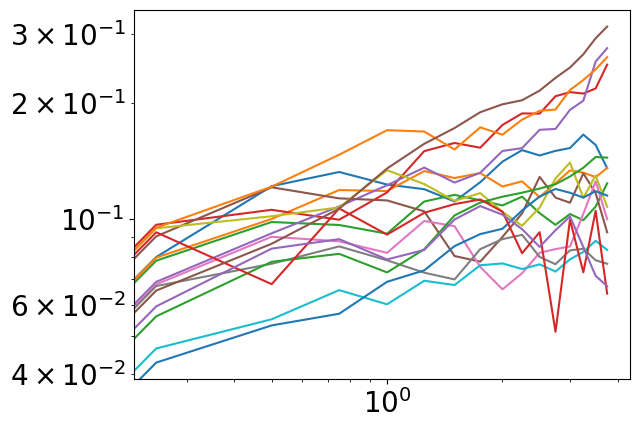

In [535]:
plt.loglog(np.array(range(MLV_msds.T.shape[0]))*0.25, MLV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_time", _xticks=True, _yticks=True, tighten=False)

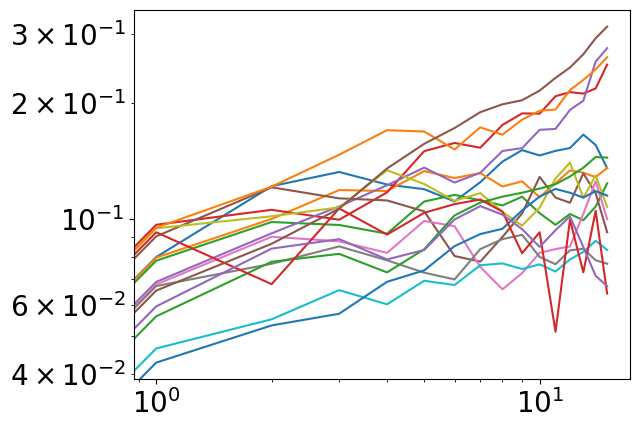

In [536]:
plt.loglog(MLV_msds.T)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV", _xticks=True, _yticks=True, tighten=False)

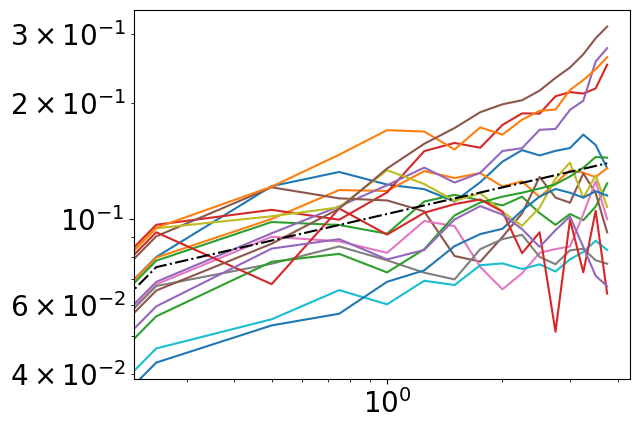

In [537]:
plt.loglog(np.array(range(MLV_msds.T.shape[0]))*0.25, MLV_msds.T)
_T = np.mgrid[0:MLV_msds.T.shape[0]*0.25:0.25]
a, b = (*np.mean(MLV_parameters_msd,axis=0),)
plt.plot(_T, f_MSD(_T, a*(4 ** b), b), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_dashed_time", _xticks=True, _yticks=True, tighten=False)

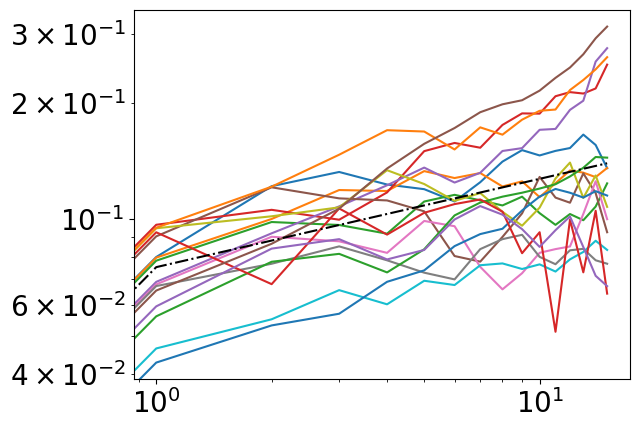

In [538]:
plt.loglog(MLV_msds.T)
_T = np.mgrid[0:MLV_msds.T.shape[0]]
plt.plot(_T, f_MSD(_T, *np.mean(MLV_parameters_msd,axis=0)), 'k-.')
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_dashed", _xticks=True, _yticks=True, tighten=False)

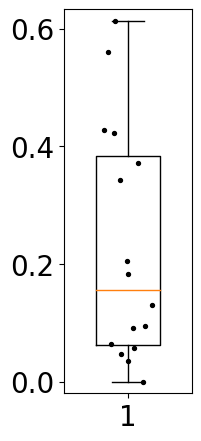

In [539]:
plt.boxplot(MLV_parameters_msd[:,1], widths=[0.5], meanline=True)
x = np.random.normal(1,0.1,size=(MLV_parameters_msd.shape[0]))
plt.scatter(x,MLV_parameters_msd[:,1], s=8, color='black')
plt.ylim([0-g_BoxExtra,max([MFV_parameters_msd[:,1].max(),MLV_parameters_msd[:,1].max()])+g_BoxExtra])
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "MSD/MLV_powers", _xticks=False, _yticks=True, tighten=False)

#### Linear

In [391]:
(*np.mean(MLV_parameters_msd,axis=0),),(*np.mean(MLV_parameters_rd,axis=0),)

((0.14010274407007478, 0.2263072767869118),
 (-0.10656961907910022, -0.0056446254604118435))

In [392]:
(*np.std(MLV_parameters_msd,axis=0),),(*np.std(MLV_parameters_rd,axis=0),)

((0.037367670457255454, 0.19284158651532146),
 (0.6632029307292469, 0.04751277449900543))

#### Kernel - Polynomial

In [446]:
(*np.mean(MLV_parameters_msd,axis=0),),(*np.mean(MLV_parameters_rd,axis=0),)

((0.07526533907124514, 0.22773427515809946),
 (-0.10897650979765436, -0.005866004460232555))

In [447]:
(*np.std(MLV_parameters_msd,axis=0),),(*np.std(MLV_parameters_rd,axis=0),)

((0.019703973653324526, 0.19329232237058605),
 (0.6412513450636755, 0.04789059501331693))

#### Kernel - RBF

In [333]:
(*np.mean(MLV_parameters_msd,axis=0),),(*np.mean(MLV_parameters_rd,axis=0),)

((0.05404002116092668, 0.2264935843504593),
 (-0.10353574855686465, -0.005413143249821425))

In [334]:
(*np.std(MLV_parameters_msd,axis=0),),(*np.std(MLV_parameters_rd,axis=0),)

((0.014486369187546352, 0.1932313528881539),
 (0.671875862833434, 0.04785373904389882))

# END